In [14]:
"""Script developed to study the driveline calibration issue. Here I'm comparing
2 variants using 2 different cals, one with a correction for the driveline.
"""

import matplotlib.pyplot as plt
import numpy as np
import base.geometry.transformations as T
from data.tools import zed

In [15]:
VAR_BASE="/home/brice/tmp/pcu_stale_driveline"
RANGE="20201206T171101-kitt_41@1607274963+30s"
#RANGE="20201206T171101-kitt_41@1607274847+20s"

def get_uri(ws, var):
    return "chum://{}?i={}/{},$default&v={}".format(RANGE, VAR_BASE, ws, var)

def load_global_vel(uri):
    reader = zed.from_chum(uri, topics=["/driving/mofo/swf_solver_state"])
    states = reader.driving_mofo_swf_solver_state[:]
    vx, vy, vz = [], [], []
    for i in range(len(states)):
        # velocity in world frame
        vw = np.array([states.pose.v_w.x[i], states.pose.v_w.y[i], states.pose.v_w.z[i]])
        # rotation
        M = T.quaternion_matrix([
            states.pose.t_wb.quaternion_rotation.w[i],
            states.pose.t_wb.quaternion_rotation.x[i],
            states.pose.t_wb.quaternion_rotation.y[i],
            states.pose.t_wb.quaternion_rotation.z[i]])
        # velocity in body frame
        vb = np.dot(M[:3,:3].T, vw)

        vx.append(vb[0])
        vy.append(vb[1])
        vz.append(vb[2])
    
    return {
        "t": states.pose.time,
        "vx": np.array(vx),
        "vy": np.array(vy),
        "vz": np.array(vz),
    }

def load_steering_angles(uri):
    reader = zed.from_chum(uri, topics=["/vehicle/measurements"])
    # Keep only the individual timestamps for the wheel speed measurements
    dynamics = reader.vehicle_measurements[:].dynamics
    t, idx = np.unique(dynamics.time_stamp_steer_angle, return_index=True)
    return {
        "t": t.astype('float64') * 1e-9, 
        "a": dynamics.steer_angle_north[idx],
    }

In [27]:
data = {
    "old": {
        "uri": get_uri("old_cal", "batch"),
        "color": "r",
    },
    "new": {
        "uri": get_uri("new_cal_rot", "batch"),
        "color": "b",
    },
}

for d in data.values():
    d["v"] = load_global_vel(d["uri"])
    d["steer"] = load_steering_angles(d["uri"])

INFO:absl:Processing input...
INFO:absl:Loading 30.0 seconds of data.
INFO:absl:URI:
    vehicle: "kitt_41"
    start_time_ns: 1607274963000000000
    end_time_ns: 1607274993000000000
    start_time_format: kSecondsSinceEpoch
    end_time_format: kSecondsSinceEpoch
    input: "/home/brice/tmp/pcu_stale_driveline/old_cal"
    input: "$default"
    variant: "batch"
    
INFO:absl:Loading data for topic `/driving/mofo/swf_solver_state` into attribute `driving_mofo_swf_solver_state`
INFO:absl:Processing input...
INFO:absl:Loading 30.0 seconds of data.
INFO:absl:URI:
    vehicle: "kitt_41"
    start_time_ns: 1607274963000000000
    end_time_ns: 1607274993000000000
    start_time_format: kSecondsSinceEpoch
    end_time_format: kSecondsSinceEpoch
    input: "/home/brice/tmp/pcu_stale_driveline/old_cal"
    input: "$default"
    variant: "batch"
    
INFO:absl:Loading data for topic `/vehicle/measurements` into attribute `vehicle_measurements`
INFO:absl:Processing input...
INFO:absl:Loading 30

In [28]:
for k, d in data.items():
    print(k + ": " + d["uri"])

old: chum://20201206T171101-kitt_41@1607274963+30s?i=/home/brice/tmp/pcu_stale_driveline/old_cal,$default&v=batch
new: chum://20201206T171101-kitt_41@1607274963+30s?i=/home/brice/tmp/pcu_stale_driveline/new_cal_rot,$default&v=batch


In [30]:
for k, d in data.items():
    vx = d["v"]["vx"]
    vy = d["v"]["vy"]
    d["v"]["vy_mean"] = np.mean(vy)
    print("{} vy mean: {}".format(k, d["v"]["vy_mean"]))
    d["v"]["v_angle"] = np.arctan2(vy, vx)
    d["v"]["v_angle_mean"] = np.mean(d["v"]["v_angle"])    
    print("{} mean v angle (degrees): {}".format(k, np.degrees(d["v"]["v_angle_mean"])))
print("mean steering angle: {} degrees".format(np.mean(np.degrees(data["old"]["steer"]["a"]))))

old vy mean: 0.03076585378150661
old mean v angle (degrees): 0.24920333907650047
new vy mean: 0.0038879026590745106
new mean v angle (degrees): 0.0456114544604554
mean steering angle: -0.11783985478015328 degrees


Text(0, 0.5, 'steering (degrees)')

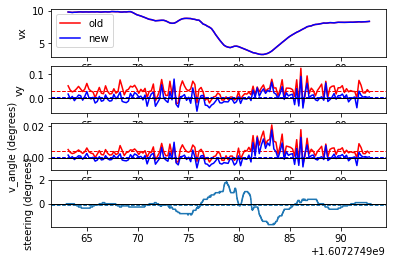

In [31]:
ax = plt.subplot(411)
for k, d in data.items():
    plt.plot(d["v"]["t"], d["v"]["vx"], label=k, color=d["color"])
plt.ylabel("vx")
plt.legend()
plt.subplot(412, sharex=ax)
for k, d in data.items():
    plt.plot(d["v"]["t"], d["v"]["vy"], label=k, color=d["color"])
    plt.axhline(y=d["v"]["vy_mean"], color=d["color"], linestyle='--', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.ylabel("vy")
plt.subplot(413, sharex=ax)
for k, d in data.items():
    plt.plot(d["v"]["t"], d["v"]["v_angle"], label=k, color=d["color"])
    plt.axhline(y=d["v"]["v_angle_mean"], color=d["color"], linestyle='--', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.ylabel("v_angle (degrees)")
plt.subplot(414, sharex=ax)
plt.plot(data["old"]["steer"]["t"], np.degrees(data["old"]["steer"]["a"]))
plt.axhline(y=np.mean(np.degrees(data["old"]["steer"]["a"])), linestyle='--', linewidth=1)
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.ylabel("steering (degrees)")